In [1]:
from utils.compute_metrics import *
from utils.compute_metrics import dfpr_score, dfnr_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd

from SMOTEBoost.SMOTEBoost import SMOTEBoostClassifier
from AdaFair.AdaFair import AdaFairClassifier
from AdaptiveWeights.AdaptiveWeights import AdaptiveWeightsClassifier
from RAMOBoost.RAMOBoost import RAMOBoostClassifier
from CUSBoost.CUSBoost import CUSBoostClassifier

from utils.load_and_preprocess import load_kdd, load_compas, load_adult_census, load_bank
from utils.plot_bars import plot_bars

from tqdm import tqdm

from IPython.display import clear_output




In [9]:
base_clf_ab = DecisionTreeClassifier(max_depth=2)
base_clf_sb = DecisionTreeClassifier(max_depth=5)
base_clf_af = DecisionTreeClassifier(max_depth=2)
base_clf_aw = LogisticRegression(solver='liblinear')

random_state = 42

def criterion(y_true, y_pred, sensitive):
    acc = accuracy_score(y_true, y_pred)
    dfpr = dfpr_score(y_true, y_pred, sensitive)
    dfnr = dfnr_score(y_true, y_pred, sensitive)
    return 2 * acc - abs(dfpr) - abs(dfnr)

models = {'AdaBoost':AdaBoostClassifier(base_clf_ab, n_estimators=200),
          'SMOTEBoost':SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
          'AdaFair':AdaFairClassifier(base_clf_af, 4, 20, 500),
          #'AdaptiveWeights':AdaptiveWeightsClassifier(base_clf_aw, criterion), 
          'RAMOBoost':RAMOBoostClassifier(),
          'CUSBoost':CUSBoostClassifier(n_estimators=10, depth=5)}

def get_score_dic(scores):
    scores_dic = {"Accuracy": scores[0],
                  "Bal. Acc.": scores[1],
                  "Eq.Odds": scores[2],
                  "TPR Prot.": scores[3],
                  "TPR Non-prot.": scores[4],
                  "TNR Prot.": scores[5],
                  "TNR Non-prot.": scores[6]}
    return scores_dic


## Adult Census Dataset

In [11]:
adult_census_path = 'datasets/adult.csv'

X, y, sensitive = load_adult_census(adult_census_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_adult_census = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_adult_census = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Adult Census Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_adult_census = get_score_dic(scores)
        for score, value in scores_adult_census.items():
            results_adult_census.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_adult_census.copy()
save_results.to_csv("results/adult_census_results.csv")


100%|██████████| 10/10 [09:36<00:00, 57.64s/it]


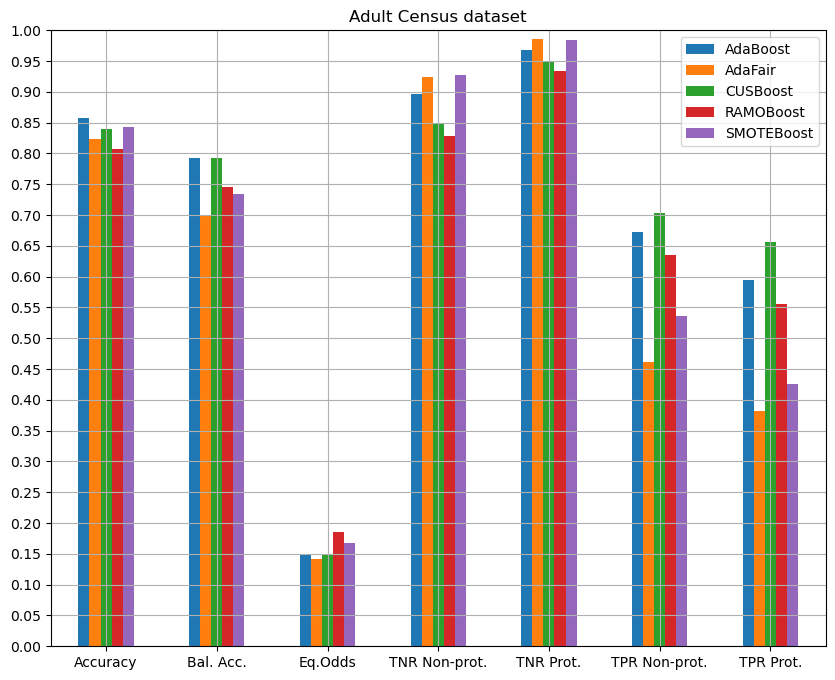

'Mean scores for Adult Census Dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.858153,0.792158,0.149346,0.895843,0.968329,0.672141,0.595281
AdaFair,0.823931,0.699010,0.141929,0.924301,0.985633,0.462113,0.381515
CUSBoost,0.840207,0.792035,0.148678,0.848603,0.950571,0.702870,0.656159
RAMOBoost,0.807805,0.746343,0.185819,0.828165,0.934201,0.635814,0.556030
SMOTEBoost,0.842802,0.734886,0.167234,0.928092,0.984765,0.536306,0.425745


'Std of scores for Adult Census Dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.004128,0.006434,0.025519,0.008168,0.006251,0.014660,0.032921
AdaFair,0.002912,0.007892,0.031542,0.012244,0.004662,0.023744,0.039454
CUSBoost,0.009979,0.020252,0.090063,0.051986,0.013333,0.077342,0.058716
RAMOBoost,0.005912,0.008810,0.057688,0.009667,0.005681,0.015132,0.052059
SMOTEBoost,0.008579,0.022005,0.054080,0.013687,0.007083,0.055792,0.036049


In [12]:
results_adult_census = pd.read_csv("results/adult_census_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_adult_census, title='Adult Census dataset')
display('Mean scores for Adult Census Dataset', mean)
display('Std of scores for Adult Census Dataset', std)

## Bank Dataset

In [14]:
bank_path = 'datasets/bank.csv'
X, y, sensitive = load_bank(bank_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_bank = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_bank = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training Bank Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_bank= get_score_dic(scores)
        for score, value in scores_bank.items():
            results_bank.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_bank.copy()
save_results.to_csv("results/bank_results.csv")

100%|██████████| 10/10 [06:12<00:00, 37.25s/it]


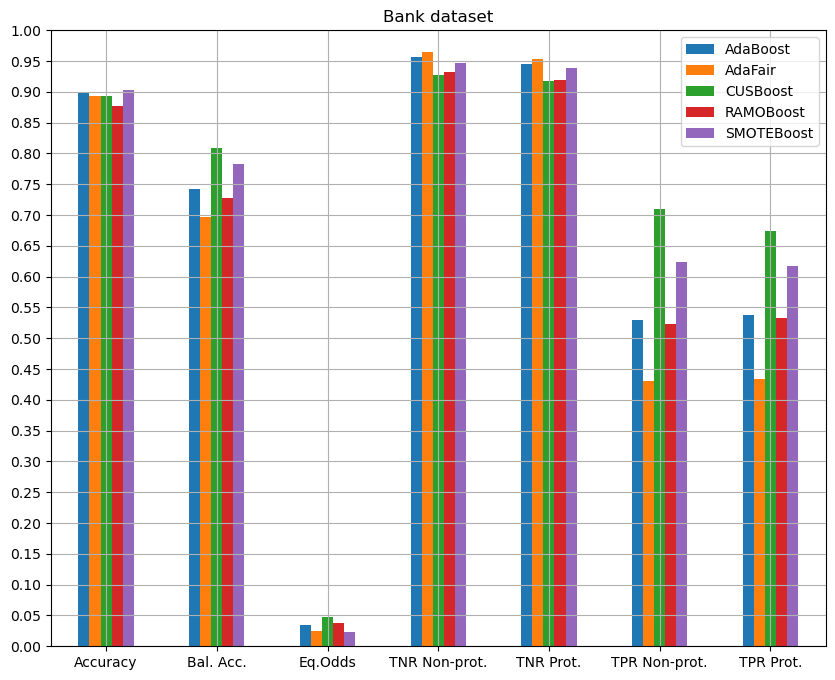

'Mean scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.898793,0.742839,0.034932,0.956854,0.944489,0.530281,0.538418
AdaFair,0.893046,0.696076,0.024237,0.964021,0.954010,0.430612,0.434233
CUSBoost,0.893768,0.808350,0.048173,0.927060,0.917005,0.709346,0.674654
RAMOBoost,0.876601,0.727254,0.038197,0.932896,0.919404,0.522829,0.532449
SMOTEBoost,0.902860,0.782458,0.023657,0.947457,0.938443,0.623930,0.618082


'Std of scores for Bank dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.002424,0.008714,0.033527,0.004400,0.004624,0.033177,0.030142
AdaFair,0.004849,0.010706,0.014987,0.003973,0.004172,0.026009,0.024161
CUSBoost,0.005375,0.025643,0.038848,0.011401,0.010201,0.066506,0.063029
RAMOBoost,0.004380,0.013346,0.034368,0.003247,0.008777,0.035907,0.044189
SMOTEBoost,0.004487,0.024194,0.018029,0.010128,0.011419,0.055112,0.063584


In [15]:
results_bank = pd.read_csv("results/bank_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_bank, title='Bank dataset')
display('Mean scores for Bank dataset', mean)
display('Std of scores for Bank dataset', std)

## KDD Census dataset

In [21]:
kdd_path = 'datasets/kdd_census_income.csv'
X, y, sensitive = load_kdd(kdd_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_kdd = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_kdd = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training KDD Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_kdd= get_score_dic(scores)
        for score, value in scores_kdd.items():
            results_kdd.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_kdd.copy()
save_results.to_csv("results/kdd_results.csv")

100%|██████████| 10/10 [1:31:47<00:00, 550.73s/it]


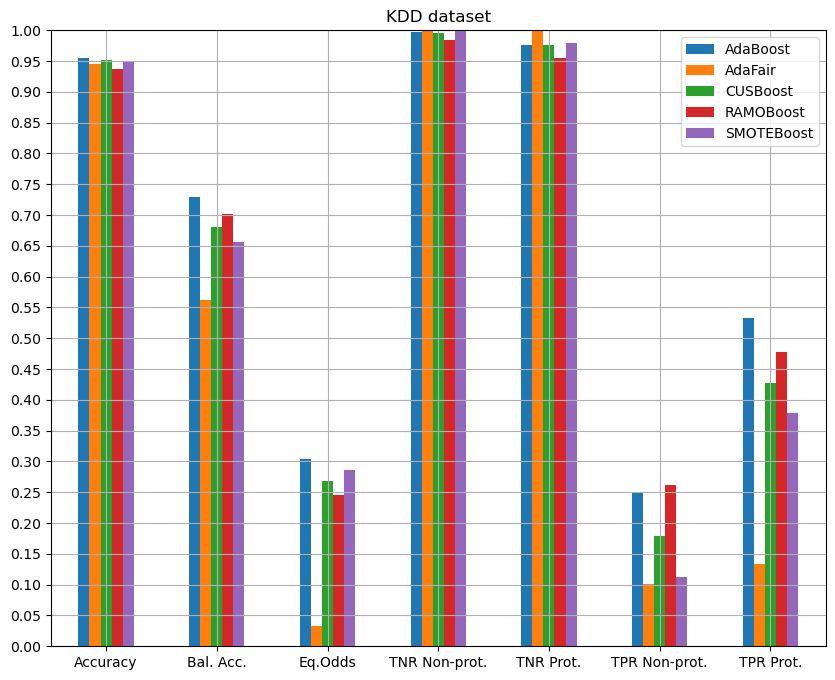

'Mean scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.955159,0.729484,0.304715,0.996789,0.975744,0.249188,0.532858
AdaFair,0.944458,0.562790,0.033255,0.998579,0.998497,0.101027,0.134164
CUSBoost,0.951025,0.681251,0.267653,0.996331,0.976701,0.179777,0.427799
RAMOBoost,0.937233,0.701119,0.245622,0.984444,0.954467,0.262274,0.477918
SMOTEBoost,0.948517,0.655872,0.286318,0.998952,0.979402,0.112385,0.379152


'Std of scores for KDD dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.000818,0.005468,0.025259,0.001031,0.002354,0.022247,0.013412
AdaFair,0.000375,0.003989,0.009245,0.000366,0.000211,0.008138,0.009149
CUSBoost,0.001119,0.009873,0.062965,0.001039,0.003904,0.045200,0.027429
RAMOBoost,0.021906,0.035209,0.036595,0.019300,0.041971,0.118625,0.095835
SMOTEBoost,0.001420,0.020744,0.064751,0.000663,0.009475,0.010385,0.057739


In [22]:
results_kdd = pd.read_csv("results/kdd_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_kdd, title='KDD dataset')
display('Mean scores for KDD dataset', mean)
display('Std of scores for KDD dataset', std)

## COMPAS dataset

In [19]:
compas_path = 'datasets/compas-scores-two-years_works.csv'
X, y, sensitive = load_compas(compas_path)
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive, shuffle=True, random_state=random_state)

X_train_array, y_train_array, s_train_array = np.array(X_train.copy()), np.array(y_train.copy()), np.array(s_train.copy())
X_test_array, y_test_array, s_test_array = np.array(X_test.copy()), np.array(y_test.copy()), np.array(s_test.copy())

score_names = ['Accuracy', 'Bal. Acc.', 'Eq.Odds', 'TPR Prot.', 'TPR Non-prot.', 'TNR Prot.', 'TNR Non-prot.']
results_compas = pd.DataFrame(index=models.keys(), columns=score_names)

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

splits = folds.split(X, y)
n_splits = folds.get_n_splits()

columns = pd.MultiIndex.from_product([list(models.keys()), score_names], names=["Classifier", "Score"])
results_compas = pd.DataFrame(index=range(n_splits), columns=columns)
prog_bar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(prog_bar):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    s_train, s_test = sensitive.iloc[train_index], sensitive.iloc[test_index]
    for model_name in models.keys():
        print(f'Training COMPAS Dataset on {model_name}')
        print('-------------------------------------------------')
        model = models[model_name]

        if model_name != 'CUSBoost':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores = compute_metrics(y_test, y_pred, s_test)
        else:
            model.fit(X_train_array, y_train_array)
            y_pred = model.predict(X_test_array)[0]
            scores = compute_metrics(y_test_array, y_pred, s_test_array)

        scores_compas= get_score_dic(scores)
        for score, value in scores_compas.items():
            results_compas.loc[i, (model_name, score)] = value
    clear_output(wait=True)

save_results = results_compas.copy()
save_results.to_csv("results/compas_results.csv")

100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


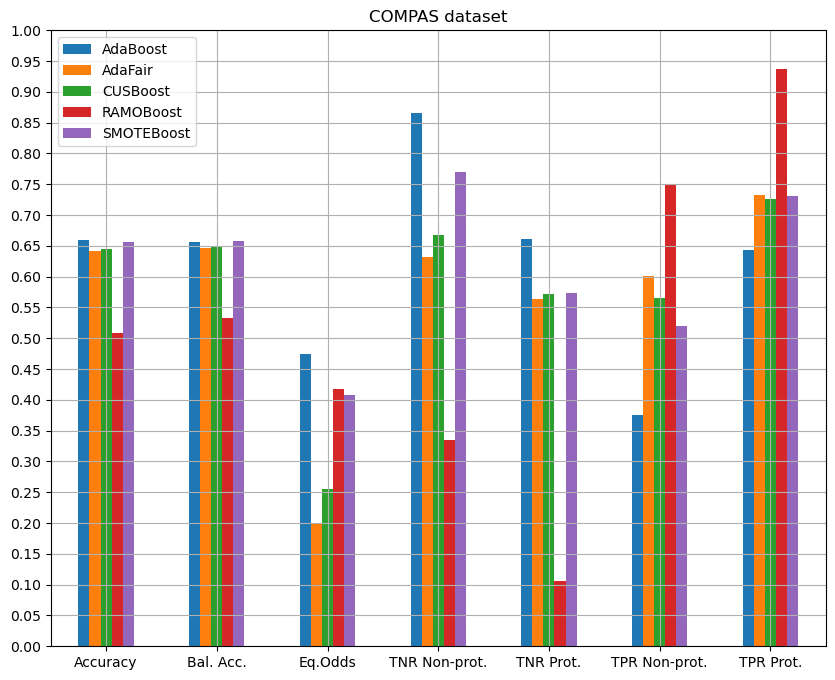

'Mean scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.659317,0.655692,0.473736,0.866225,0.661275,0.375042,0.643828
AdaFair,0.642016,0.646507,0.199264,0.632014,0.564210,0.601753,0.733213
CUSBoost,0.645059,0.648103,0.255716,0.666857,0.571855,0.565686,0.726400
RAMOBoost,0.508195,0.533497,0.417848,0.335012,0.106020,0.748099,0.936956
SMOTEBoost,0.655642,0.658291,0.407925,0.770179,0.572706,0.519729,0.730182


'Std of scores for COMPAS dataset'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoost,0.010371,0.010844,0.221917,0.058628,0.050842,0.097383,0.051862
AdaFair,0.011731,0.017878,0.082693,0.127953,0.105001,0.143385,0.139381
CUSBoost,0.016827,0.015472,0.183150,0.087544,0.058925,0.075121,0.032564
RAMOBoost,0.018061,0.016630,0.252132,0.139120,0.052527,0.105974,0.013137
SMOTEBoost,0.020410,0.016942,0.160327,0.092324,0.089613,0.098730,0.066965


In [20]:
results_compas = pd.read_csv("results/compas_results.csv", index_col=[0], header=[0, 1])
mean, std = plot_bars(results_compas, title='COMPAS dataset')
display('Mean scores for COMPAS dataset', mean)
display('Std of scores for COMPAS dataset', std)